In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax, flax
from jax import jit
import sys
import os
from tqdm.auto import tqdm
import pandas as pd

os.environ['CUDA_VISIBLE_DEVICES'] = '2,3,4,5'
import visualization, network
from network import shard

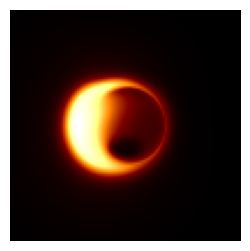

In [2]:
image_shape = [100, 100]
image = np.array(pd.read_csv('avery_sgra_eofn.txt', comment='#', header=None, delimiter=' ')[2]).reshape(image_shape)

plt.figure(figsize=(3,3))
plt.axis('off')
plt.imshow(image, cmap='afmhot')

In [3]:
def loss_pixels(params, predictor_fn, coords, pixel_values):
    prediction = predictor_fn({'params': params}, coords)
    loss = jnp.sum(jnp.abs(pixel_values - prediction)**2)
    return loss

@jit
def gradient_step(state, coords, pixel_values):
    loss_fn = lambda params: loss_pixels(params, state.apply_fn, coords, pixel_values)
    loss, grads = jax.value_and_grad(loss_fn, argnums=(0))(state.params)
    grads = jax.lax.pmean(grads, axis_name='batch')
    loss = jax.lax.pmean(loss, axis_name='batch')
    state = state.apply_gradients(grads=grads)
    return loss, state

grad_pmap = jax.pmap(gradient_step, axis_name='batch', in_axes=(0, 0, 0))

  0%|          | 0/50000 [00:00<?, ?it/s]

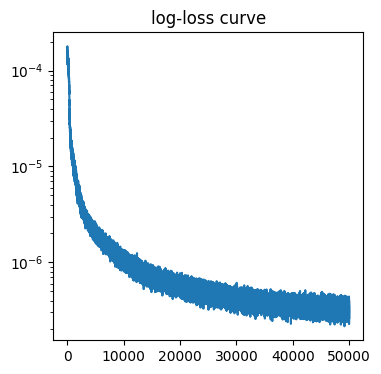

In [11]:
# Co-location points 
x = np.linspace(-0.5, 0.5, image_shape[0])
y = np.linspace(-0.5, 0.5, image_shape[1])
coords = np.stack(np.meshgrid(x, y, indexing='ij'), axis=-1).reshape(-1, 2)
pixel_values = jnp.array(image.ravel())

num_iters = 50000
batchsize = 2048    # Should be a multiple of number of GPUs used (see jax.device_count())
posenc_deg = 6
predictor = network.PixelPredictor(scale=np.array([1.0, 1.0]), posenc_deg=posenc_deg)
params = predictor.init_params(coords[0])
state = predictor.init_state(params, num_iters)

# Training loop
loss_curve = []
for i in tqdm(range(num_iters)):
    batch = np.random.randint(0, coords.shape[0], batchsize)
    loss, state = grad_pmap(state, shard(coords[batch]), shard(pixel_values[batch]))
    loss_curve.append(np.mean(loss))
    
params = jax.device_get(flax.jax_utils.unreplicate(state.params))
image_nn = np.array(predictor.apply({'params': params}, coords).reshape(image_shape))

plt.figure(figsize=(4,4))
plt.title('log-loss curve')
plt.semilogy(loss_curve)

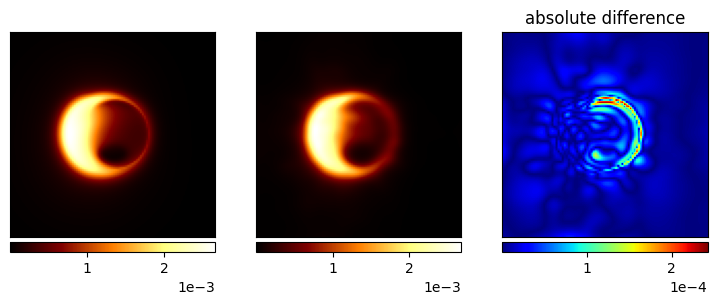

In [13]:
fig, axes = visualization.compare_images(image, image_nn)